In [73]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [74]:
def parse_dat_file_to_dataframe(file_path):
    # List to store event data (each event is a dict)
    events_data = []
    current_event = {}
    event_number = None

    with open(file_path, 'r') as file:
        for line in file:
            line = line.strip()  # Remove leading/trailing spaces
            
            # Detect the start of a new event
            event_match = re.match(r'% Event (\d+)', line)
            if event_match:
                # If we are in the middle of an event, store it before moving to the next one
                if current_event:
                    events_data.append(current_event)
                    current_event = {}
                
                # Start a new event
                event_number = int(event_match.group(1))
                current_event['Event'] = event_number
            
            # Split the key-value pairs and store them in the current_event dict
            elif line and not line.startswith('%'):
                key_value = line.split('\t')
                if len(key_value) == 2:
                    key, value = key_value
                    current_event[key] = float(value) if value.replace('.', '', 1).isdigit() else value

        # Append the last event after reading the file
        if current_event:
            events_data.append(current_event)
    
    # Convert list of event dictionaries to a DataFrame
    df = pd.DataFrame(events_data)
    
    return df

In [75]:
folder = "O:/Nat_ASVAP/OMLAB_DATA/ASVAP_press_"
month = "Sept2024/"
run = "Run-031"

start_file = 1
path_intial = folder+month+run+"/"+run+f"-00{start_file}.dat"
path = folder+month+run
num_files = 243


In [76]:
df = parse_dat_file_to_dataframe(path_intial)
for i in range(start_file+1,num_files+1):
    
    if i <10:
        next_file = parse_dat_file_to_dataframe(path+"/"+run+f"-00{i}.dat")
    elif 10 <= i <100:
        next_file = parse_dat_file_to_dataframe(path+"/"+run+f"-0{i}.dat")
    elif 100 <= i:
        next_file = parse_dat_file_to_dataframe(path+"/"+run+f"-{i}.dat")
    df = pd.concat([df,next_file],ignore_index=True)
zero_indices = df.index[df['Some_calibration'] == 0.0].tolist()
df = df.drop(index=zero_indices).reset_index(drop=True)

In [129]:
def linfunc(x, a, b):
    return x*a + b

def expfunc(x, a, b ,c):
    return a* np.exp( x * b) + c

def lnfunc(x,a,b,c):
    return  a*np.log(b*x) +c

xdata = ((df["Time_ms"]-df["Time_ms"][0])*2.7778*10**(-7)) #Time in hours
ydata = df["TC_CH1_Samp_C"]#.astype(float) * 10**(-7) #convert to 1e-7 mbar
popt, pcov = curve_fit(lnfunc, xdata[30:],ydata[30:] )
print(popt, np.diag(pcov))

[ 3.18051866 13.75996401 22.39992468] [2.03541056e-04 9.70471018e+11 5.18494149e+10]


Text(0.5, 1.0, 'heating system turned on for main chamber')

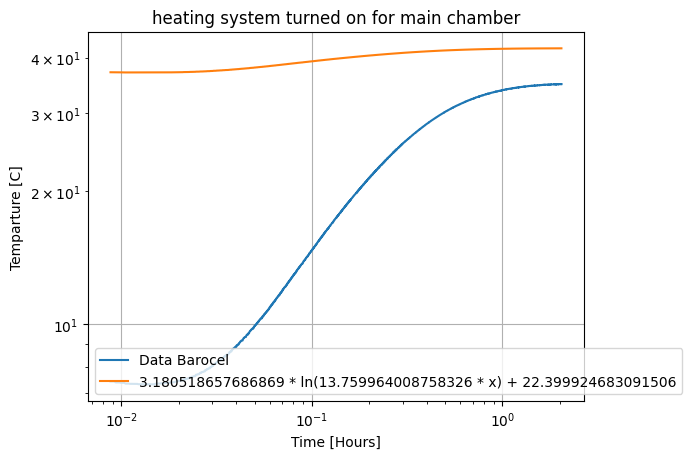

In [130]:
plt.loglog(xdata[30:7000],ydata[30:7000], label="Data Barocel")
# plt.loglog(xdata, expfunc(xdata,*popt), label="{:.3f} * exp({:.3f} * x ) {:.3f}".format(*popt))
# plt.plot(xdata, linfunc(xdata,*popt), label="{:.7f}*x + {:.7f}".format(*popt))
plt.loglog(xdata[30:7000], lnfunc(ydata[30:7000], *popt), label="{} * ln({} * x) + {}".format(*popt))
plt.xlabel("Time [Hours]")
plt.ylabel("Temperature [C]")
plt.grid()
plt.legend()
plt.title("heating system turned on for main chamber")
# plt.savefig("Cooling trans with main heat run 30")

In [79]:
df["TC_CH1_Samp_C"]

0        22.525389
1        22.525389
2        22.491982
3        22.491982
4        22.339806
           ...    
24295    34.947456
24296    34.947456
24297    34.940254
24298    34.940254
24299    34.954956
Name: TC_CH1_Samp_C, Length: 24300, dtype: float64